# LP Liquidity vs Prices

## Intro

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from dotenv import load_dotenv


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm, trange

from helixirapi.helixir_api import HelixirApi

### Create client instance

In [4]:
load_dotenv()
AUTH_TOKEN = os.getenv("AUTH_TOKEN")
client = HelixirApi(auth_token=AUTH_TOKEN)
client

## Example

Select `contract` of LP Token, _time interval_ and `resolution`.

In [5]:
# contract = "0x2c7a7ef1de5d007f16401BBe80b127d9B94b0D9d"
contract = "0xEa26B78255Df2bBC31C1eBf60010D78670185bD0"
from_ = "2022-01-01"
to = "2022-06-01"
resolution = "H1"

lp_token = client.get_lp_token(contract=contract)
lp_token

LPTokenResponse(
	id = 4,
	name = Pancake LPs,
	symbol = ETH/USDC,
	chain = BSC,
	decimals = 18.0,
	total_supply = 181490.764628607,
	contract = 0xEa26B78255Df2bBC31C1eBf60010D78670185bD0,
	token_0 = TokenResponse(
		id = 8,
		name = Ethereum Token,
		symbol = ETH,
		chain = BSC,
		active = False,
		decimals = 18.0,
		total_supply = 1404999.9999908486,
		circulating_supply = 1404988.249821321,
		contract = 0x2170Ed0880ac9A755fd29B2688956BD959F933F8,
	),
	token_1 = TokenResponse(
		id = 9,
		name = USD Coin,
		symbol = USDC,
		chain = BSC,
		active = False,
		decimals = 18.0,
		total_supply = 1879000000.0,
		circulating_supply = 1878999624.013729,
		contract = 0x8AC76a51cc950d9822D68b83fE1Ad97B32Cd580d,
	),
)

In [6]:
liquidity = pd.DataFrame([l.__dict__ for l in client.get_lps_liquidity(
    contract=contract,
    from_=from_,
    to=to,
    resolution=resolution,
)]).set_index("time")
liquidity

Iterating requests to meet the limit:   0%|          | 0/11 [00:00<?, ?it/s]

,liquidity_0,liquidity_1
time,,
2021-12-31 23:00:00+00:00,5022.631380,1.850245e+07
2022-01-01 00:00:00+00:00,4994.950628,1.860586e+07
2022-01-01 01:00:00+00:00,4988.978059,1.862840e+07
2022-01-01 02:00:00+00:00,4993.144098,1.861318e+07
2022-01-01 03:00:00+00:00,4987.275906,1.863072e+07
...,...,...
2022-05-31 17:00:00+00:00,5710.515933,1.120660e+07
2022-05-31 18:00:00+00:00,5757.504277,1.111547e+07
2022-05-31 19:00:00+00:00,5755.547201,1.111831e+07


In [7]:
price_0 = pd.DataFrame([p.__dict__ for p in client.get_candles(
    contract=lp_token.token_0.contract,
    from_=from_,
    to=to,
    resolution=resolution,
)]).set_index("time")["close"].rename("price_0")

price_1 = pd.DataFrame([p.__dict__ for p in client.get_candles(
    contract=lp_token.token_1.contract,
    from_=from_,
    to=to,
    resolution=resolution,
)]).set_index("time")["close"].rename("price_1")

df = liquidity.join(
    pd.DataFrame({"price_0": price_0, "price_1": price_1})
)
df

Iterating requests to meet the limit:   0%|          | 0/11 [00:00<?, ?it/s]

Iterating requests to meet the limit:   0%|          | 0/11 [00:00<?, ?it/s]

,liquidity_0,liquidity_1,price_0,price_1
time,,,,
2021-12-31 23:00:00+00:00,5022.631380,1.850245e+07,3689.354097,1.000538
2022-01-01 00:00:00+00:00,4994.950628,1.860586e+07,3723.588584,1.000491
2022-01-01 01:00:00+00:00,4988.978059,1.862840e+07,3734.333303,1.002032
2022-01-01 02:00:00+00:00,4993.144098,1.861318e+07,3722.738657,1.000712
2022-01-01 03:00:00+00:00,4987.275906,1.863072e+07,3731.669947,0.997253
...,...,...,...,...
2022-05-31 17:00:00+00:00,5710.515933,1.120660e+07,1963.620246,0.999883
2022-05-31 18:00:00+00:00,5757.504277,1.111547e+07,1934.361957,1.000344
2022-05-31 19:00:00+00:00,5755.547201,1.111831e+07,1935.508447,1.000414


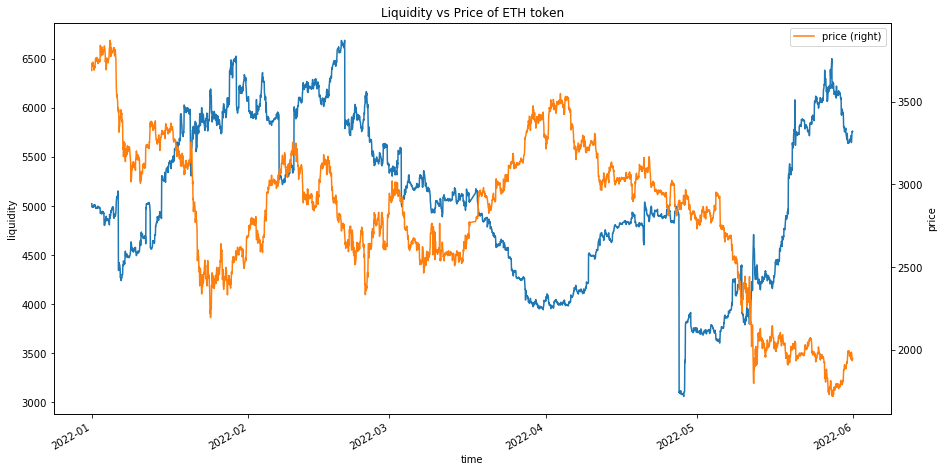

In [8]:
plt.figure(figsize=(15, 8))
ax_l = df["liquidity_0"].plot(label="liquidity")
ax_l.set_ylabel("liquidity")
ax_p = df["price_0"].fillna(method="ffill").plot(secondary_y=True, label="price")
ax_p.set_ylabel("price")
plt.title(f"Liquidity vs Price of {lp_token.token_0.symbol} token")
plt.legend()
plt.show()

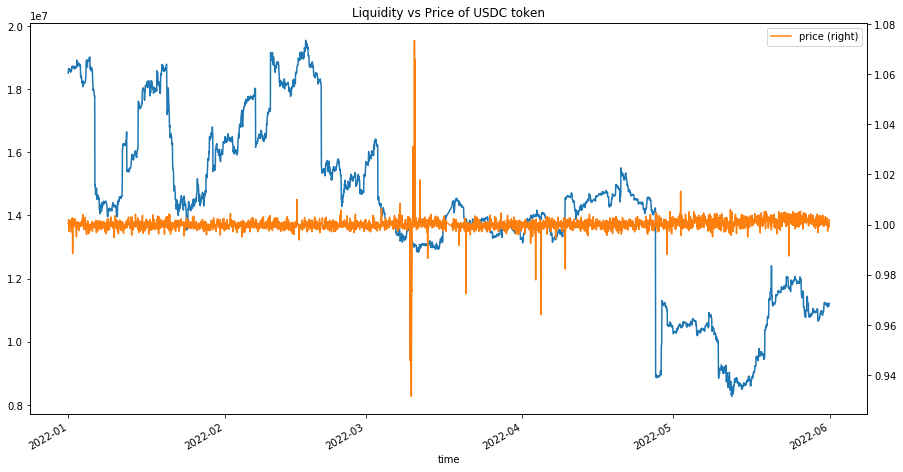

In [9]:
plt.figure(figsize=(15, 8))
df["liquidity_1"].plot(label="liquidity")
df["price_1"].fillna(method="ffill").plot(secondary_y=True, label="price")
plt.title(f"Liquidity vs Price of {lp_token.token_1.symbol} token")
plt.legend()
plt.show()